In [27]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import datetime as dt
import pickle
import gradio as gr
import time
from datetime import date, timedelta
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
%matplotlib inline

from google.oauth2.service_account import Credentials
import logging

from oauth2client.service_account import ServiceAccountCredentials

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import sqlalchemy as db
from sqlalchemy import create_engine
import mysql.connector
import psycopg2

from powerbiclient import Report, models
from powerbiclient.authentication import MasterUserAuthentication
from powerbiclient.authentication import ServicePrincipalAuthentication
from powerbiclient.authentication import DeviceCodeLoginAuthentication
from powerbiclient.authentication import InteractiveLoginAuthentication
from io import StringIO
import ipywidgets
from ipywidgets import interact
import requests

In [13]:
MyData = pd.read_csv('C:/Users/leemn/Downloads/deploy/Income_Expense_Data.csv')
MyData.head()

,Age,Income,Expense
0,25,40000.0,20000
1,26,35000.0,18000
2,27,90000.0,60000
3,32,70000.0,28000
4,31,75000.0,32000


In [14]:
MyData["Income"].fillna((MyData["Income"].median()), inplace = True)

In [15]:
Age_col_df = pd.DataFrame(MyData['Age'])
Age_median = Age_col_df.median()

#getting IQR of Age column
Q3 = Age_col_df.quantile(q=0.75)
Q1 = Age_col_df.quantile(q=0.25)
IQR = Q3-Q1

#Deriving boundaries of Outliers
IQR_LL = int(Q1 - 1.5*IQR)
IQR_UL = int(Q3 + 1.5*IQR)

#Finding and treating outliers - both lower and upper end
MyData.loc[MyData['Age']>IQR_UL , 'Age'] = int(Age_col_df.quantile(q=0.99))
MyData.loc[MyData['Age']<IQR_LL , 'Age'] = int(Age_col_df.quantile(q=0.01))

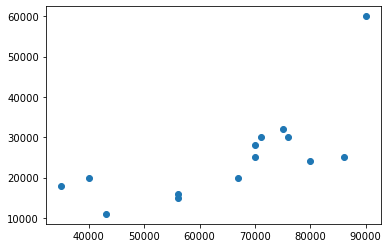

In [16]:
x = MyData["Income"]
y=  MyData["Expense"]


plt.scatter(x, y, label="Income Expense")

<AxesSubplot:>

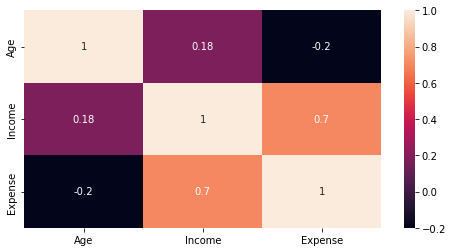

In [17]:
#check correltion matrix - to check the strength of variation bwtween two variables
correlation_matrix= MyData.corr().round(2)
f, ax = plt.subplots(figsize =(8, 4)) 
import seaborn as sns
sns.heatmap(data=correlation_matrix, annot=True)

In [18]:
################feature engineering#######################
#Normalization/scaling of data - understanding scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(MyData)
scaled_data

array([[0.        , 0.09090909, 0.18367347],
       [0.01098901, 0.        , 0.14285714],
       [0.02197802, 1.        , 1.        ],
       [0.07692308, 0.63636364, 0.34693878],
       [0.06593407, 0.72727273, 0.42857143],
       [0.05494505, 0.65454545, 0.3877551 ],
       [0.24175824, 0.63636364, 0.28571429],
       [1.        , 0.74545455, 0.3877551 ],
       [0.26373626, 0.38181818, 0.10204082],
       [0.32967033, 0.58181818, 0.18367347],
       [0.31868132, 0.81818182, 0.26530612],
       [0.34065934, 0.92727273, 0.28571429],
       [0.38461538, 0.38181818, 0.08163265],
       [0.40659341, 0.14545455, 0.        ]])

In [19]:
#converting data back to pandas dataframe
MyData_scaled = pd.DataFrame(scaled_data)
MyData_scaled.columns = ["Age","Income","Expense"]

In [20]:
#Separating features and response
features = ["Income","Age"]
response = ["Expense"]
X = MyData_scaled[features]
y = MyData_scaled[response]

In [21]:
#Importing neccesary packages
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [22]:
#Dividing data in test and train

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [23]:
#Fitting lineaar regression model
model = LinearRegression()
model.fit(X_train, y_train)
accuracy = model.score(X_test,y_test)
print(accuracy*100,'%')

67.82333705931673 %


In [24]:
#Dumping the model object
import pickle
pickle.dump(model, open('expense_pred.pkl','wb'))

In [25]:
#Reloading the model object
expense_pred = pickle.load(open('expense_pred.pkl','rb'))
print(model.predict([[30000, 24]]))

[[17711.51531007]]


## Deploy model using Gradio

In [31]:
def predict_expense(income, age):
    """
    Predict someone's expense based on age and income.
    This function uses a pickled scikitlearn model to predict the expense.
    The output is a predicted expense.
    """
    # Load the model
    expense_pred = pickle.load(open("expense_pred.pkl", "rb"))
    # Predict the expense
    expense = expense_pred.predict([[income, age]])
    # Return the expense
    return expense


app = gr.Interface(
    predict_expense,
    inputs=[
        gr.Number(value=2000, label="Income"),
        gr.Number(value=21, label="Age"),
    ],
    outputs=[gr.Text(label="Expense")],
)

app.launch()
#app.launch(share=True) - to share it publicly - public for 72hours

Running on local URL:  http://127.0.0.1:7869/

To create a public link, set `share=True` in `launch()`.


(<gradio.routes.App at 0x2ad52043df0>, 'http://127.0.0.1:7869/', None)